## MAS Mandate 2 - Extension

In this simulation, we will look at how agents can choose between two products and how influencers can manipulate these choices.

This code has been built on top of [Austin Rochford](https://austinrochford.com/posts/thoughtless-python-mesa.html)'s work.

In [1]:
!pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 14.7 MB/s eta 0:00:00


In [2]:
import mesa 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

random.seed(10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Consumer agent

In [3]:
class Consumer(mesa.Agent):
    """
        @class Consumer
        Agent properties
            - Radius of influence 
            - Choice of product 1 or 2 (modelled as choice = False or True)
            - Tendency to get influenced (influencers can exploit this through conditioning)
    """
    def __init__(self, unique_id, model, max_radius = 50, conditioned = False, tendency_factor = 1.000):
        super().__init__(unique_id, model)
        self.choice = random.choice([False, True])
        self.radius = random.randint(1, max_radius)
        self.tendency = random.random()
        self.tendency_factor = tendency_factor
        if conditioned:
            self.tendency *= 2

    """
        @method get_change_percent()
        Gets the percentage of agents within the agent's vicinity that are willing to change their choice
    """ 
    def get_change_percent(self):
        neighbours = self.model.grid.iter_neighbors(self.pos, moore = True, radius = self.radius)
        count = sum([n.choice for n in neighbours])
        return count/(2*self.radius + 1) 
    
    """
        @method update_radius()
        Generates a random "advertising value score", and based on this, the agent will increase or decrease their radius.
        If the value of the advertisement is higher than the agent's tendency, the radius is increased; and vice-versa.
    """
    def update_radius(self):
        advertisement_score = random.random()
        if advertisement_score <= self.tendency:
            self.radius += 1 
        else:
            self.radius -= 1

    """
        @method update_choice()
        Computes the change percent and updates the agent's choice accordingly
    """
    def update_choice(self):
        change_percent = self.get_change_percent()
        self.choice = change_percent >= 0.5

    """ 
        @method update_tendency() 
        Increases the tendency of the agent to get influenced as the time passes
    """
    def update_tendency(self):
        self.tendency *= self.tendency_factor


    """ 
        @method step()
        Simulates a time step
    """
    def step(self):
        self.update_tendency()
        self.update_radius()
        self.update_choice()

#### Consumer model

In [4]:
class ConsumerModel(mesa.Model):
    """
        @class ConsumerModel
        Model properties
            - Number of agents
            - They are positioned on a circular grid
    """
    def __init__(self, num_agents = 200, agent_cls = Consumer, **kwargs):
        self.grid = mesa.space.SingleGrid(num_agents, 1, torus = True) # Circular grid 
        self.schedule = mesa.time.RandomActivation(self)

        for agent_id in range(num_agents):
            agent = agent_cls(agent_id, self, **kwargs)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (agent_id, 0))
            self.datacollector = mesa.DataCollector(agent_reporters={"choice": "choice", "radius": "radius"})
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

#### Helper function for visualisation

In [5]:
"""
    Visualisation of each agent's choice and radius
"""
def plot_results(model, cmap="viridis", figsize=(16, 6)):
    agent_df = model.datacollector.get_agent_vars_dataframe()
    
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                             figsize=figsize, gridspec_kw={"width_ratios": (0.85, 1)})
    norm_ax, radius_ax = axes
    
    sns.heatmap(agent_df["choice"].unstack(),
                cmap=cmap, vmin=0, vmax=1, cbar=False,
                ax=norm_ax)
    
    norm_ax.set_xticks([])
    norm_ax.set_xlabel("Agent")
    
    norm_ax.set_yticks([])
    norm_ax.set_ylabel("Step")
    
    norm_ax.set_title("choice")
    
    rhm = sns.heatmap(agent_df["radius"].unstack(),
                     cmap=cmap, vmin=1, vmax=10,
                     ax=radius_ax)
    
    radius_ax.set_xticks([])
    radius_ax.set_xlabel("Agent")
    
    radius_ax.set_yticks([])
    radius_ax.set_ylabel(None)
    
    radius_ax.set_title("radius")

    fig.tight_layout()
    
    return fig, axes

## Experiment 1
In this experiment, we set the max_radius to be 50 and keep the tendencies constant throughout the experiment.

In [6]:
from tqdm import tqdm

def simulate(model, num_steps):
    for _ in tqdm(range(num_steps)):
        model.step()

    return model

In [7]:
model1 = simulate(ConsumerModel(
    num_agents = 750,
), num_steps = 250)

100%|██████████| 250/250 [00:20<00:00, 12.49it/s]


(<Figure size 1600x600 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'choice'}, xlabel='Agent', ylabel='Step'>,
        <AxesSubplot: title={'center': 'radius'}, xlabel='Agent'>],
       dtype=object))

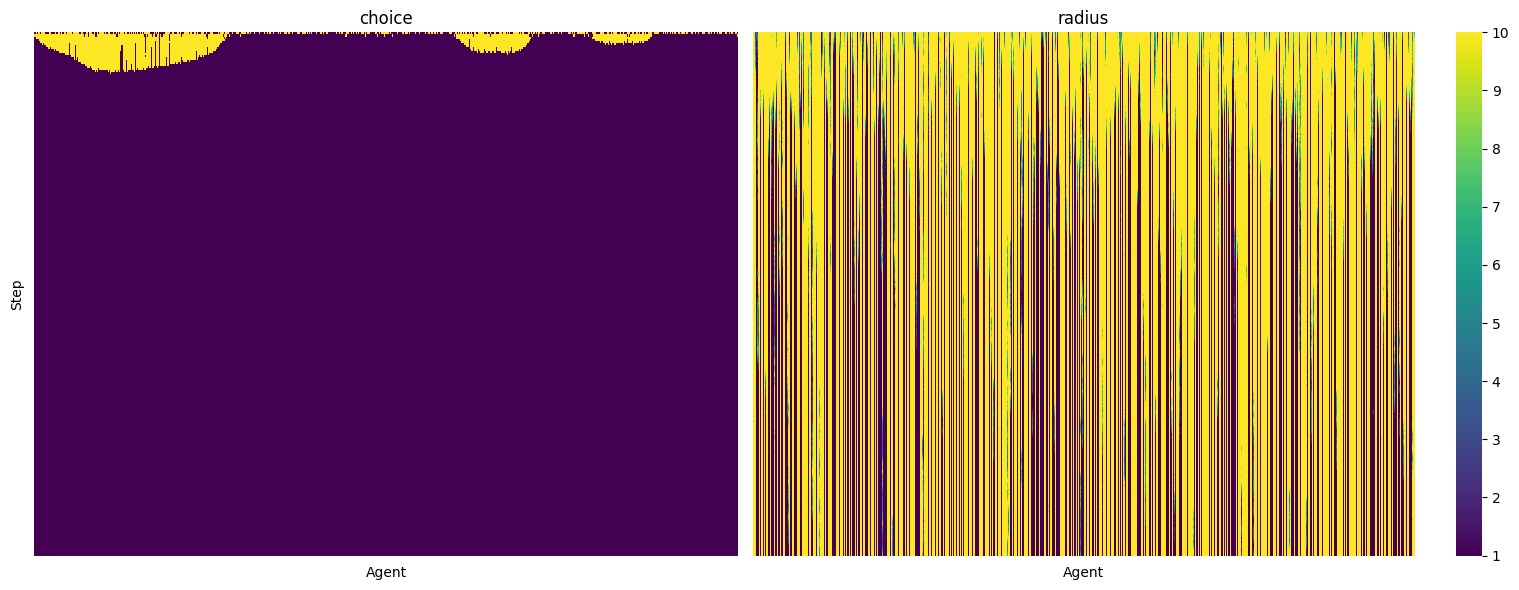

In [8]:
plot_results(model1)

## Experiment 2

In this experiment, we increase the `max_radius` field and also increase tendencies to get influenced

In [9]:
model2 = simulate(ConsumerModel(
    num_agents = 750,
    max_radius = 100,
    tendency_factor = 1.005
), num_steps = 250)

100%|██████████| 250/250 [00:46<00:00,  5.40it/s]


(<Figure size 1600x600 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'choice'}, xlabel='Agent', ylabel='Step'>,
        <AxesSubplot: title={'center': 'radius'}, xlabel='Agent'>],
       dtype=object))

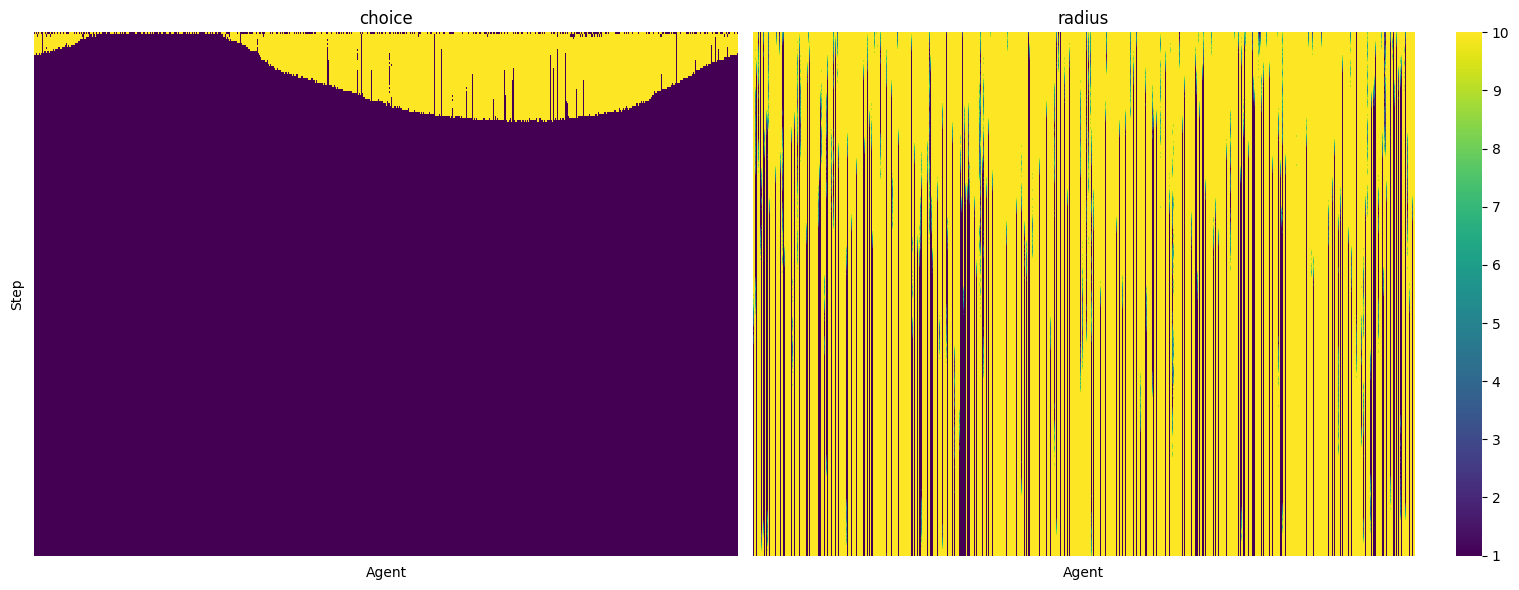

In [10]:
plot_results(model2)

## Experiment 3

In this experiment, we increase the `max_radius` field but decrease the tendencies to get influenced

In [11]:
model3 = simulate(ConsumerModel(
    num_agents = 750,
    max_radius = 100,
    tendency_factor = 0.99
), num_steps = 250)

100%|██████████| 250/250 [00:09<00:00, 25.43it/s]


(<Figure size 1600x600 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'choice'}, xlabel='Agent', ylabel='Step'>,
        <AxesSubplot: title={'center': 'radius'}, xlabel='Agent'>],
       dtype=object))

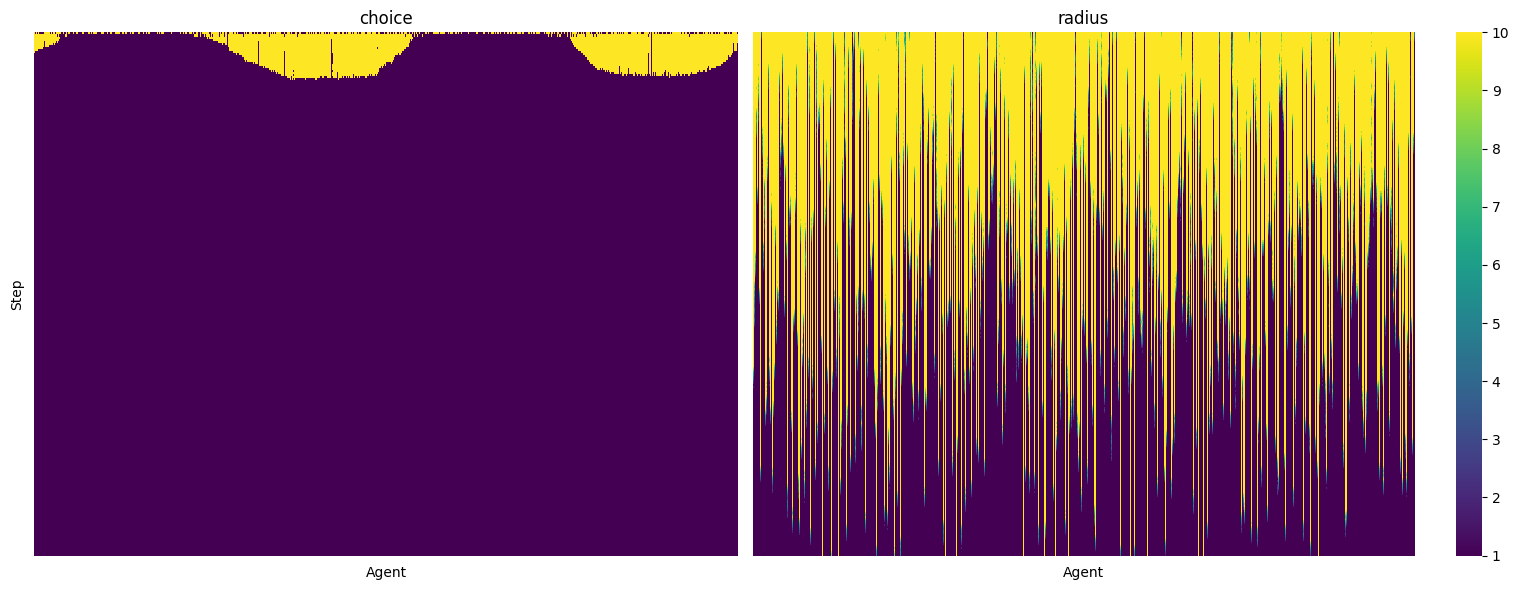

In [12]:
plot_results(model3)

## Experiment 4

In this experiment, we increase the `max_radius` field but emulate a very famous influencer by setting the `conditioned` field to True and increasing the `tendency_factor` field drastically.

In [16]:
model4 = simulate(ConsumerModel(
    num_agents = 750,
    max_radius = 100,
    conditioned = True,
    tendency_factor = 1.05
), num_steps = 250)

100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


(<Figure size 1600x600 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'choice'}, xlabel='Agent', ylabel='Step'>,
        <AxesSubplot: title={'center': 'radius'}, xlabel='Agent'>],
       dtype=object))

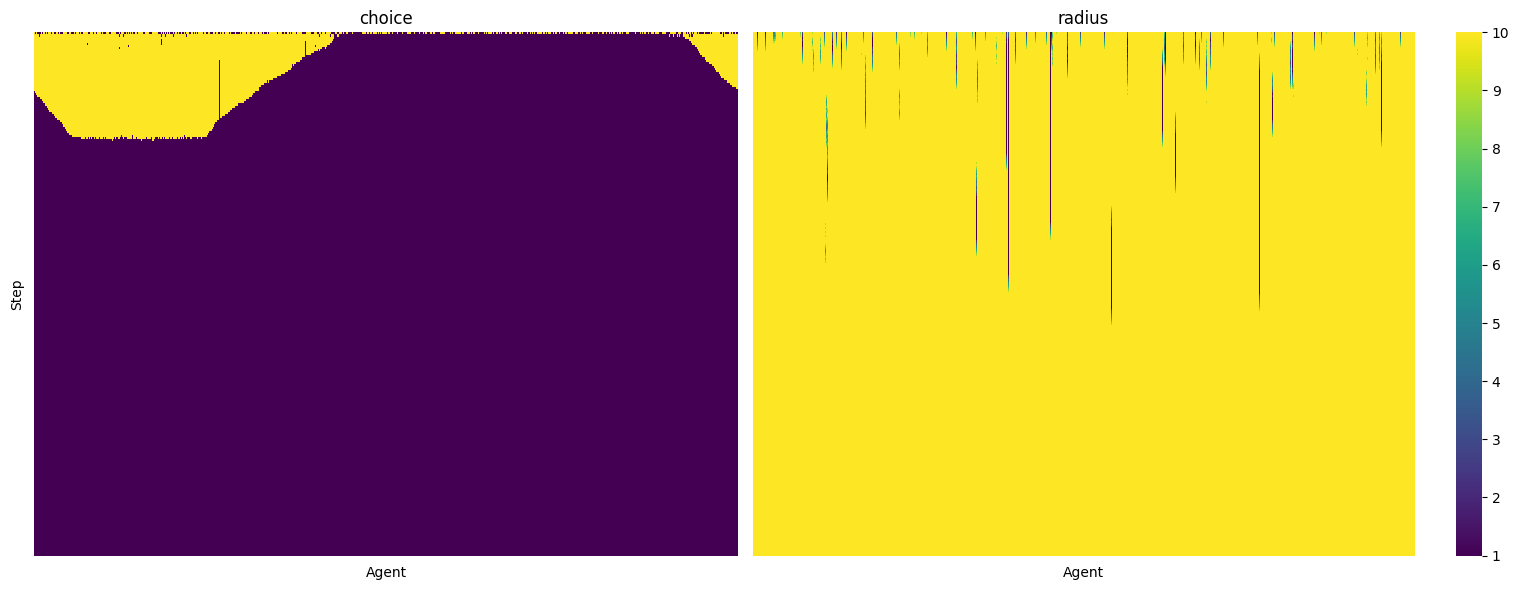

In [17]:
plot_results(model4)